Constante k estimada: 0.69315
La hora estimada de la muerte fue alrededor de las 10:28 a.m.


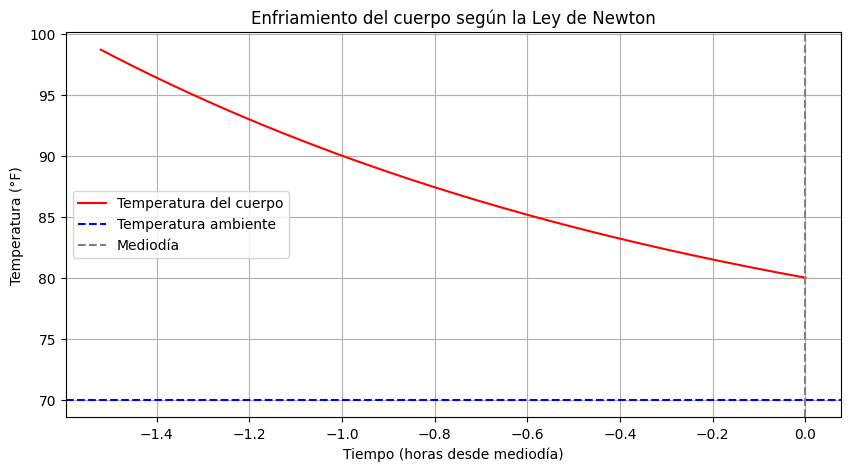

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros iniciales conocidos
T_amb = 70  # Temperatura ambiente constante (°F)
T_mediodia = 80  # Temperatura del cuerpo al mediodía (12:00 p.m.)
T_1pm = 75       # Temperatura del cuerpo a la 1:00 p.m.
t0 = 0           # Tiempo en horas desde el mediodía
t1 = 1           # Tiempo a la 1:00 p.m.
h = 0.01         # Paso de tiempo para método de Euler mejorado

# ------------------------------
# 1. Determinar la constante k
# ------------------------------

# EDO: dT/dt = -k(T - T_amb)
# Método de Euler mejorado (Heun) para estimar k usando los datos a mediodía y a la 1 p.m.

def heun_method_k(T0, T1_real, t0, t1, h, T_amb):
    """
    Usamos Heun para estimar el valor de k tal que T(t=1) ≈ 75°F
    """
    def heun(T0, k, h, t0, t1):
        n = int((t1 - t0) / h)
        T = T0
        for i in range(n):
            t = t0 + i*h
            f1 = -k * (T - T_amb)
            T_predict = T + h * f1
            f2 = -k * (T_predict - T_amb)
            T = T + h * (f1 + f2)/2
        return T

    # Búsqueda de k usando método de búsqueda binaria
    k_low, k_high = 0.001, 1.0
    while k_high - k_low > 1e-6:
        k_mid = (k_low + k_high) / 2
        T1_est = heun(T0, k_mid, h, t0, t1)
        if T1_est > T1_real:
            k_low = k_mid
        else:
            k_high = k_mid
    return k_mid

# Estimamos k usando los datos dados
k_est = heun_method_k(T_mediodia, T_1pm, t0, t1, h, T_amb)
print(f"Constante k estimada: {k_est:.5f}")

# ------------------------------------------
# 2. Usamos Heun hacia atrás para hallar hora de muerte
# ------------------------------------------

def heun_backward_until(T_init, T_target, h, k, T_amb):
    """
    Integramos hacia atrás en el tiempo hasta que T ≈ 98.6°F (hora de muerte)
    """
    T = T_init
    t = 0  # tiempo actual desde mediodía
    times = [t]
    temps = [T]

    while T < T_target:
        f1 = -k * (T - T_amb)
        T_predict = T - h * f1  # Nota: resta porque vamos hacia atrás
        f2 = -k * (T_predict - T_amb)
        T = T - h * (f1 + f2)/2
        t -= h
        times.append(t)
        temps.append(T)

    return np.array(times), np.array(temps)

# Calculamos la evolución hacia atrás hasta 98.6°F
times_back, temps_back = heun_backward_until(T_mediodia, 98.6, h, k_est, T_amb)

# Tiempo estimado de muerte
tiempo_muerte = times_back[-1]  # tiempo negativo en horas desde el mediodía
hora_muerte = 12 + tiempo_muerte  # en horas reloj
print(f"La hora estimada de la muerte fue alrededor de las {int(hora_muerte)}:{int((hora_muerte%1)*60):02d} a.m.")

# ------------------------------------------
# 3. Graficamos la evolución de temperatura
# ------------------------------------------
plt.figure(figsize=(10,5))
plt.plot(times_back, temps_back, label="Temperatura del cuerpo", color='red')
plt.axhline(y=70, color='blue', linestyle='--', label='Temperatura ambiente')
plt.axvline(x=0, color='gray', linestyle='--', label='Mediodía')
plt.title("Enfriamiento del cuerpo según la Ley de Newton")
plt.xlabel("Tiempo (horas desde mediodía)")
plt.ylabel("Temperatura (°F)")
plt.legend()
plt.grid(True)
plt.show()